# Proyek Klasifikasi Gambar: KITTI Object Detection

Notebook ini mencakup pipeline lengkap untuk melatih klasifikasi gambar 'Car', 'Pedestrian', 'Cyclist', dan 'Van' menggunakan dataset KITTI.

**Fitur:**
1.  **Data Loading & Augmentation**: Menggunakan `ImageDataGenerator`.
2.  **Model Architecture**: Sequential CNN dengan `Conv2D` dan `MaxPooling`.
3.  **Training**: Menggunakan Callbacks (`EarlyStopping`, `ModelCheckpoint`).
4.  **Evaluation**: Plot Akurasi dan Loss.
5.  **Inference**: Uji coba prediksi pada data baru.
6.  **Model Conversion**: Konversi ke SavedModel, TF-Lite, dan TFJS.

---

## 1. Import Library & Konfigurasi

In [1]:
import os, sys
import logging

# Suppress TensorFlow INFO and WARNING logs (Types: 0=All, 1=Filter INFO, 2=Filter INFO/WARN, 3=Filter All)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Suppress Python Warnings
import warnings
warnings.filterwarnings('ignore')

# Suppress TensorFlow Python logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

try:
    from absl import logging as absl_logging
    absl_logging.set_verbosity(absl_logging.ERROR)
except ImportError:
    pass

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import shutil
import random

DATASET_SOURCE = 'dataset' 
BASE_DIR = 'data_split'   

def split_dataset(source, target, train_ratio=0.8, val_ratio=0.1):
    if os.path.exists(target):
        shutil.rmtree(target)
    
    classes = [d for d in os.listdir(source) if os.path.isdir(os.path.join(source, d))]
    
    for cls in classes:
        # Buat folder train, val, test
        os.makedirs(os.path.join(target, 'train', cls), exist_ok=True)
        os.makedirs(os.path.join(target, 'val', cls), exist_ok=True)
        os.makedirs(os.path.join(target, 'test', cls), exist_ok=True)
        
        src_cls_path = os.path.join(source, cls)
        # Ambil hanya file gambar
        images = [f for f in os.listdir(src_cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.seed(42)
        random.shuffle(images)
        
        total_images = len(images)
        train_len = int(total_images * train_ratio)
        val_len = int(total_images * val_ratio)
        
        train_imgs = images[:train_len]
        val_imgs = images[train_len:train_len + val_len]
        # Sisanya masuk ke test set (~10%)
        test_imgs = images[train_len + val_len:]
        
        for img in train_imgs:
            shutil.copy(os.path.join(src_cls_path, img), os.path.join(target, 'train', cls, img))
        for img in val_imgs:
            shutil.copy(os.path.join(src_cls_path, img), os.path.join(target, 'val', cls, img))
        for img in test_imgs:
            shutil.copy(os.path.join(src_cls_path, img), os.path.join(target, 'test', cls, img))
            
    print(f"Manual splitting selesai (Ratio: {train_ratio*100}% Train, {val_ratio*100}% Val, Sesanya Test). Dataset disimpan di: {target}")

print("Memulai proses manual splitting dataset...")
split_dataset(DATASET_SOURCE, BASE_DIR, train_ratio=0.8, val_ratio=0.1)

# Menghitung dan menampilkan jumlah data per split
def count_files(directory):
    total = 0
    for root, dirs, files in os.walk(directory):
        total += len(files)
    return total

print(f"Total data Training: {count_files(os.path.join(BASE_DIR, 'train'))}")
print(f"Total data Validation: {count_files(os.path.join(BASE_DIR, 'val'))}")
print(f"Total data Test: {count_files(os.path.join(BASE_DIR, 'test'))}")

# Konfigurasi Path Akhir
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameter Gambar
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32
TARGET_SIZE = (IMG_HEIGHT, IMG_WIDTH)

print(f"TensorFlow Version: {tf.__version__}")

Memulai proses manual splitting dataset...
Manual splitting selesai (Ratio: 80.0% Train, 10.0% Val, Sesanya Test). Dataset disimpan di: data_split
Total data Training: 8934
Total data Validation: 1115
Total data Test: 1120
TensorFlow Version: 2.19.0


## 2. Data Preparation (Augmentation)

In [2]:
# Augmentasi untuk data Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation hanya di-rescale
validation_datagen = ImageDataGenerator(rescale=1./255)

print("Loading Training Data...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical' # Multiclass 
)

print("Loading Validation Data...")
validation_generator = validation_datagen.flow_from_directory(
    VAL_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Test Data Generator (Revisi: Load seluruh data test)
print("Loading Test Data...")
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

CLASSES = list(train_generator.class_indices.keys())
print(f"Classes: {CLASSES}")

Loading Training Data...
Found 8934 images belonging to 4 classes.
Loading Validation Data...
Found 1115 images belonging to 4 classes.
Loading Test Data...
Found 1120 images belonging to 4 classes.
Classes: ['car', 'cyclist', 'pedestrian', 'van']


## 3. Membangun Arsitektur Model (CNN)

In [3]:
model = Sequential([ # Kriteria: Model Sequential CNN
    tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    # Conv Block 1
    Conv2D(32, (3, 3), activation='relu'), # Kriteria: Conv2D Layer
    MaxPooling2D(2, 2), # Kriteria: MaxPooling Layer
    
    # Conv Block 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), # Kriteria: MaxPooling Layer
    
    # Conv Block 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), # Kriteria: MaxPooling Layer
    
    # Flatten & Dense Layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    
    # Output Layer (4 Kelas: Car, Cyclist, Pedestrian, Van)
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,035,716 (72.62 MB)

 Trainable params: 19,035,716 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Training (Dengan Callbacks)

In [4]:
# Callbacks
callbacks = [
    # Hentikan training jika val_accuracy tidak naik selama 5 epochs
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True), # Kriteria: Accuracy > 85% monitored
    # Simpan model terbaik
    tf.keras.callbacks.ModelCheckpoint('saved_model/model_best.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

print("Starting Training...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks
)

Starting Training...
Epoch 1/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8037 - loss: 0.5687
Epoch 1: val_accuracy improved from None to 0.87868, saving model to saved_model/model_best.h5

Epoch 1: finished saving model to saved_model/model_best.h5
279/279 ━━━━━━━━━━━━━━━━━━━━ 47s 167ms/step - accuracy: 0.8384 - loss: 0.4747 - val_accuracy: 0.8787 - val_loss: 0.3593
Epoch 2/10
  1/279 ━━━━━━━━━━━━━━━━━━━━ 44s 159ms/step - accuracy: 0.8438 - loss: 0.3825
Epoch 2: val_accuracy did not improve from 0.87868
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8438 - loss: 0.3825 - val_accuracy: 0.8658 - val_loss: 0.4030
Epoch 3/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8681 - loss: 0.3814
Epoch 3: val_accuracy improved from 0.87868 to 0.91360, saving model to saved_model/model_best.h5

Epoch 3: finished saving model to saved_model/model_best.h5
279/279 ━━━━━━━━━━━━━━━━━━━━ 48s 171ms/step - accuracy: 0.8678 - loss: 0.3784 - val_accuracy: 0.9136 - val_loss

## 5. Evaluasi & Visualisasi

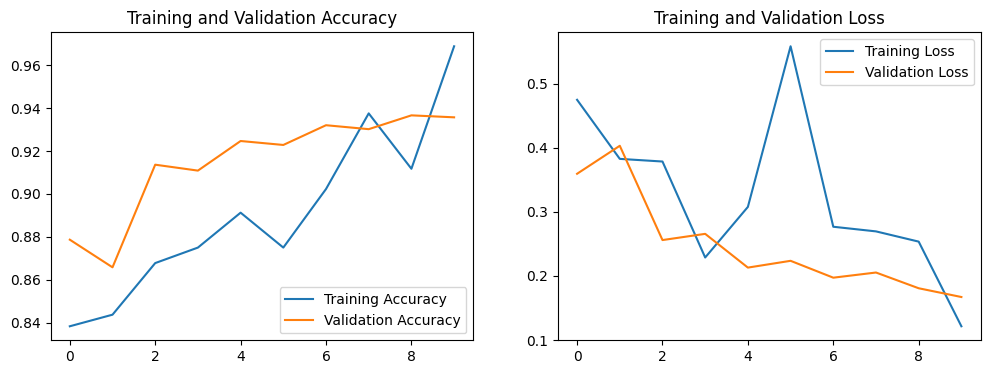

In [5]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy') # Kriteria: Plot Accuracy & Loss
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

## 6. Evaluasi Model pada Data Test

Mengevaluasi akurasi model menggunakan seluruh data pada test set (`data_split/test`) menggunakan `model.evaluate`.


Mengevaluasi model pada Test Set...
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9500 - loss: 0.1730

Test Accuracy: 95.00%
Test Loss: 0.1730
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


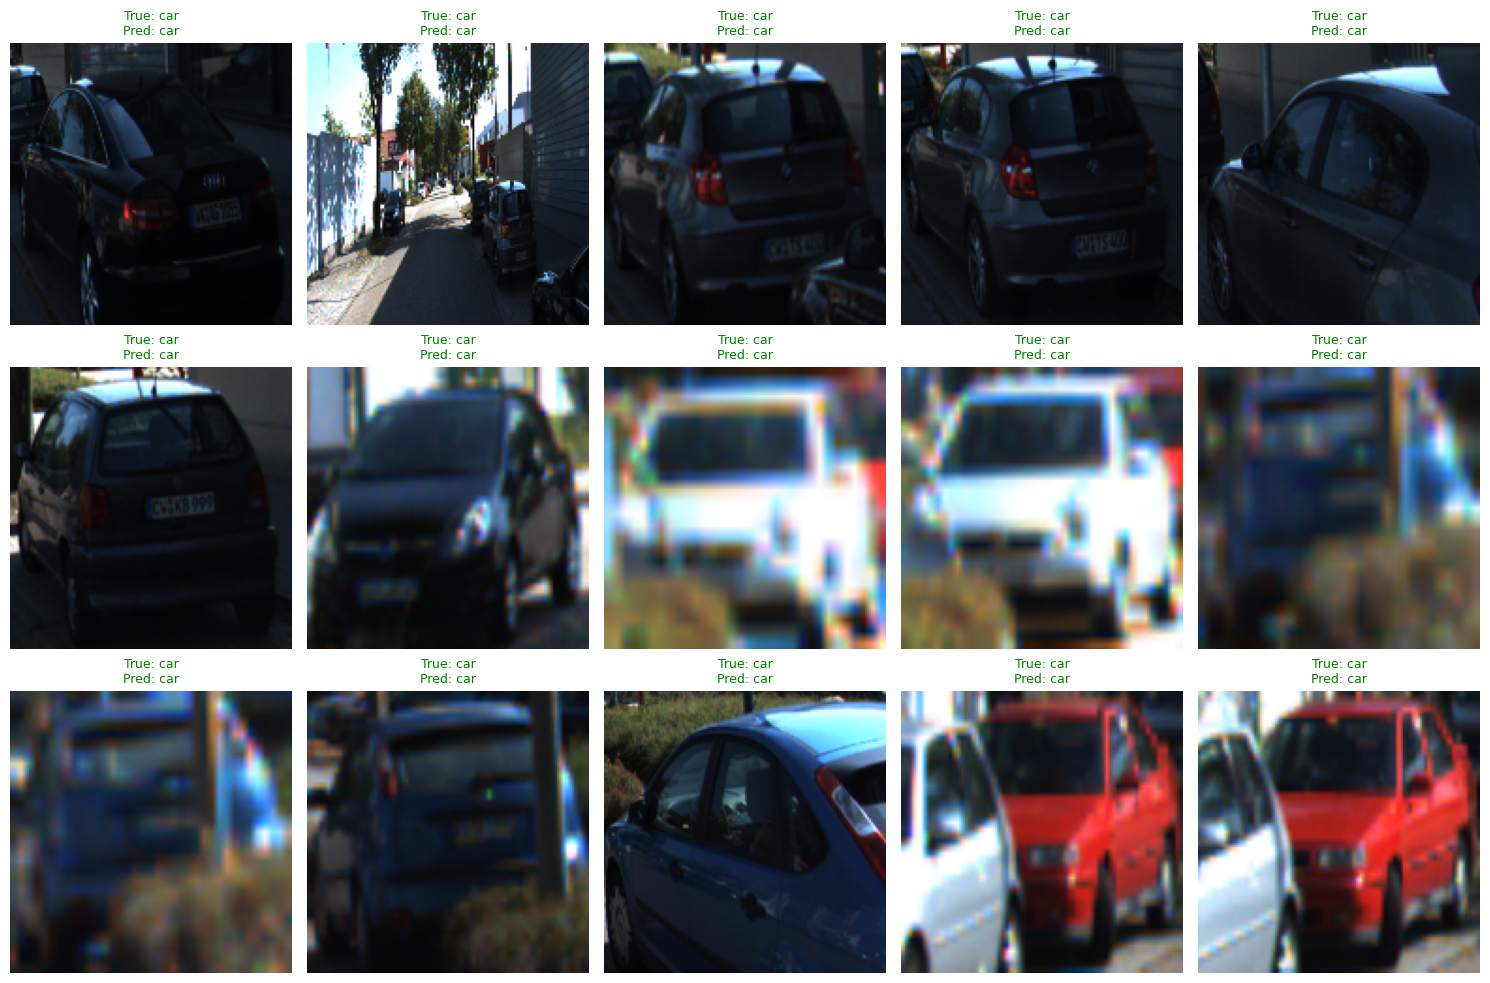

In [6]:
# Evaluasi menggunakan seluruh data test
print("Mengevaluasi model pada Test Set...")
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Visualisasi hasil prediksi (sample dari test generator)
import matplotlib.pyplot as plt
import numpy as np

# Ambil batch pertama untuk visualisasi
images, labels = next(test_generator)
preds = model.predict(images)
pred_labels = np.argmax(preds, axis=1)
true_labels = np.argmax(labels, axis=1)

class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(15, 10))
for i in range(min(15, len(images))):
    plt.subplot(3, 5, i + 1)
    plt.imshow(images[i])
    
    color = 'green' if pred_labels[i] == true_labels[i] else 'red'
    plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}", color=color, fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()


## 7. Konversi Model (SavedModel, TF-Lite, TFJS)

In [7]:
# Load Model Terbaik
best_model = load_model('saved_model/model_best.h5')

# 1. Save as SavedModel
saved_model = 'saved_model'
if os.path.exists(saved_model):
    shutil.rmtree(saved_model)
try:
    best_model.export(saved_model)
    print("✅ SavedModel exported successfully.")
except Exception as e:
    print(f"❌ SavedModel export failed: {e}")

# 2. Convert to TF-Lite
tflite_path = 'tflite/model_car_pedestrian.tflite'
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(best_model) # Kriteria: TF-Lite Conversion
    tflite_model = converter.convert()
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)
    print(f"✅ TF-Lite model saved to {tflite_path}.")
except Exception as e:
    print(f"❌ TF-Lite conversion failed: {e}")

# 3. Convert to TFJS
tfjs_model = 'tfjs_model'
if os.path.exists(tfjs_model):
    shutil.rmtree(tfjs_model)
try:
    # Patch untuk numpy compatibility di notebook
    if not hasattr(np, 'object'):
        np.object = object
    import tensorflowjs as tfjs
    tfjs.converters.convert_tf_saved_model(saved_model, tfjs_model) # Kriteria: TFJS Conversion
    print(f"✅ TFJS model saved to {tfjs_model}.")
except Exception as e:
    print(f"❌ TFJS conversion failed: {e}")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  5374487504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5385648080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5385648848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5385649424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5385649232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5385649808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5385650000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5385648464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5395759760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5395760528: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ SavedModel exported successfully.
Saved artifact at '/var/folders/x9/c

W0000 00:00:1768981617.952463 4705722 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1768981617.952488 4705722 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1768981617.956013 4705722 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


❌ TF-Lite conversion failed: [Errno 2] No such file or directory: 'tflite/model_car_pedestrian.tflite'


I0000 00:00:1768981619.144924 4705722 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
I0000 00:00:1768981619.144996 4705722 single_machine.cc:374] Starting new session


✅ TFJS model saved to tfjs_model.
